In [2]:
#| default_exp app_v3

#### Competition

[LINK](https://www.kaggle.com/competitions/playground-series-s3e11/overview)

#### Imports

In [3]:
#| export
from fastai.tabular.all import *

from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

import xgboost as xgb

import seaborn as sns

import optuna

#### Downloading Datasets

In [4]:
#| export
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [5]:
#| export
comp = 'playground-series-s3e11'
path = setup_comp(comp, install='fastai')

In [6]:
# copy .gitignore template from my home directory and append project data folder to it
if not os.path.exists('.gitignore'):
    !cp ~/.gitignore .
if comp not in open('.gitignore').read():
    with open('.gitignore', 'a') as f: f.write(f'{comp}')

#### Create Dataframes

In [7]:
#| export
df_train = pd.read_csv(path/'train.csv', low_memory=False)
df_test = pd.read_csv(path/'test.csv', low_memory=False)
df_comb = pd.concat([df_train, df_test], ignore_index=True)

In [8]:
#| export
df_train.drop(['id'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)
df_comb.drop(['id'], axis=1, inplace=True)

In [9]:
df_train

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360331,7.60,4.0,5.0,5.0,3.0,13.50,1.0,0.0,33.0,30268.0,0.0,0.0,0.0,0.0,0.0,133.42
360332,14.44,4.0,4.0,0.0,4.0,18.80,1.0,1.0,18.0,20319.0,0.0,0.0,0.0,0.0,0.0,81.85
360333,10.74,3.0,0.0,0.0,2.0,11.30,1.0,0.0,35.0,30584.0,1.0,1.0,1.0,1.0,1.0,87.07
360334,11.04,3.0,1.0,0.0,3.0,10.20,0.0,1.0,14.0,30584.0,1.0,1.0,1.0,1.0,1.0,146.72


In [10]:
#| export
df_train['store_sales_per_children'] = df_train['store_sales(in millions)'] / df_train['total_children']

In [11]:
#| export
for column in df_train.columns:
    if (list(df_train[column].unique()) == [0.0, 1.0]):
        df_train.loc[:, column] = df_train[column].astype('bool')

In [12]:
#| export
train_idxs = np.arange(len(df_train))
test_idxs = np.arange(len(df_train), len(df_comb))

In [13]:
dep_var = 'cost'
procs = [Categorify, FillMissing, Normalize]
cont, cat = cont_cat_split(df_comb, max_card=1, dep_var=dep_var)
splits = RandomSplitter(valid_pct=0.2)(range_of(df_train))

In [14]:
df_train = df_comb.iloc[train_idxs]
df_test = df_comb.iloc[test_idxs]

In [15]:
#| export
to_final = TabularPandas(df_train, procs, cat, cont, y_names=dep_var, splits=splits)
test_final = TabularPandas(df_test, procs, cat, cont, y_names=None, splits=None)
dls_final = to_final.dataloaders(bs=1024)

In [16]:
#| export
fast_train = False
epochs = 14

#### Train Model

In [17]:
#| export
if fast_train == True:
    learn_final = tabular_learner(dls_final, layers=[200, 100], y_range=(0, 150), metrics=rmse)
    learn_final.fit_one_cycle(epochs, 1e-2)
    learn_final.export('models/tab_learner.pkl')


In [18]:
learn_final = load_learner('models/tab_learner.pkl')

In [19]:
#| export
test_dl = learn_final.dls.test_dl(df_test)
preds_final, _ = learn_final.get_preds(dl=test_dl)

#### Get Model Predictions

In [20]:
#| export
preds_final = preds_final.squeeze()

#### Random Forest Model

In [21]:
#| export
xs, y = to_final.train.xs, to_final.train.y
valid_xs, valid_y = to_final.valid.xs, to_final.valid.y
test_xs = test_final.train.xs

In [22]:
#| export
def rf(xs, y, n_estimators=40, max_samples=200_000, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, 
                                 max_samples=max_samples, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [23]:
#| export
def r_mse(pred, y):
    return round(math.sqrt(((pred-y)**2).mean()), 6)

In [24]:
#| export
def m_rmse(m, xs, y):
    return r_mse(m.predict(xs), y)

In [25]:
#| export
m = rf(xs, y, n_estimators=100)

In [26]:
rf_mse = m_rmse(m, valid_xs, valid_y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(23.180559, 28.191411)

#### Feature Importance

In [27]:
#| export
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp': m.feature_importances_}).sort_values('imp', ascending=False) 

In [28]:
fi = rf_feat_importance(m, xs)
fi

,cols,imp
0,store_sales(in millions),0.219047
5,gross_weight,0.205253
8,units_per_case,0.153730
9,store_sqft,0.102142
2,total_children,0.075347
4,avg_cars_at home(approx).1,0.063601
3,num_children_at_home,0.050391
1,unit_sales(in millions),0.035241
6,recyclable_package,0.027741
7,low_fat,0.024333


#### Gradient Boosting

##### Feature Importance

In [29]:
#| export
train_fi = df_train.drop(columns = ['cost'])
target_fi = df_train['cost']

In [30]:
#| export
def plot_fi(data,ax = None,title = None):
    fi = pd.Series(data, index = train_fi.columns).sort_values(ascending = True)
    fi.plot(kind = 'barh', ax = ax)

In [31]:
#| export
x_train, x_test, y_train, y_test = train_test_split(train_fi, target_fi, test_size=0.2)

In [32]:
#| export
fi_params = {'learning_rate': 0.2456172216493356,
 'max_depth': 10,
 'lambda': 0.0023120639864473262,
 'alpha': 0.5848465230832824,
 'colsample_bytree': 0.9966638720347625,
 'min_child_weight': 0,
 'sampling_method': 'uniform',
 'tree_method': 'gpu_hist',
 'objective': 'reg:squaredlogerror',
 'eval_metric': 'rmsle'}

In [33]:
# fi_params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'eta': 0.05,
#     'max_depth': 6,
#     'min_child_weight': 4,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
# }

In [34]:
#| export
model = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)


In [35]:
#| export
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

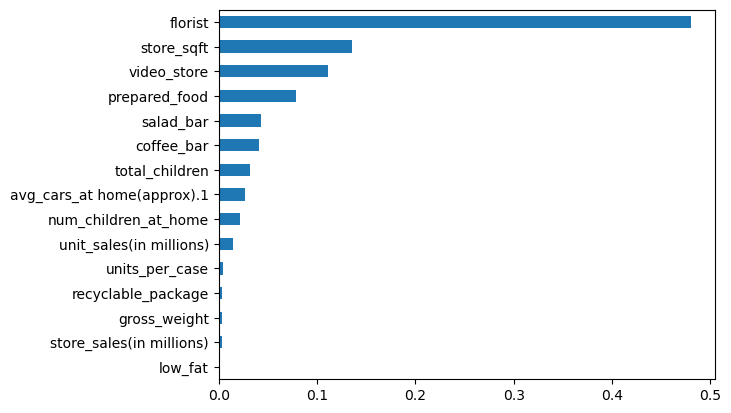

In [36]:
plot_fi(model.feature_importances_)

***

In [ ]:
gb_train = xgb.DMatrix(xs, label=y)
gb_valid = xgb.DMatrix(valid_xs, label=valid_y)
gb_test = xgb.DMatrix(test_xs)

In [ ]:
gb_train.feature_names

Set params

In [ ]:
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,
    'max_depth': 6,
    'min_child_weight': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

Train Model

In [ ]:
num_boost_round = 500
early_stopping_rounds = 10

In [ ]:
evals = [(gb_train, 'train'), (gb_valid, 'valid')]

In [ ]:
booster = xgb.train(
    xgb_params,
    gb_train,
    num_boost_round=num_boost_round,
    evals=evals,
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=20)

In [ ]:
xgb_mse = r_mse(booster.predict(gb_valid), valid_y)
xgb_mse

In [ ]:
xgb_preds = booster.predict(gb_test)

In [ ]:
#| export
rf_preds = m.predict(test_xs)

In [ ]:
#| export
ens_preds = (to_np(preds_final) + rf_preds + xgb_preds) / 3

In [ ]:
#| export
sample_df = pd.read_csv(path/'sample_submission.csv')
sample_df['cost'] = preds_final
sample_df.to_csv('submission.csv', index=False)

In [ ]:
!head submission.csv

In [ ]:
sample_df.max()

In [ ]:
submit = True

In [ ]:
if not iskaggle and submit:
    from kaggle import api
    api.competition_submit_cli(file_name='submission.csv', message="drop id column", competition=comp)

In [ ]:
import nbdev
nbdev.export.nb_export('media_campaign_cost_boost.ipynb', 'app_v3')
print("export successful")